# Описание проекта

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

1. лог сервера с данными об их посещениях,
2. выгрузка их покупок за этот период,
3. рекламные расходы.

Вам предстоит изучить:

1. откуда приходят пользователи и какими устройствами они пользуются,
2. сколько стоит привлечение пользователей из различных рекламных каналов;
3. сколько денег приносит каждый клиент,
4. когда расходы на привлечение клиента окупаются,
5. какие факторы мешают привлечению клиентов.


# Импортируем библиотеки

In [1]:
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
from datetime import datetime, timedelta


# Шаг 1. Загрузите данные и подготовьте их к анализу


In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()
print()
orders.info()
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column 

## Приводим к нижнему регистру

In [4]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [5]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [6]:
costs.columns = costs.columns.str.lower().str.replace(' ', '_')
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


## Приводим к нужному типу 

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [9]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

## Пропуски

In [10]:
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [11]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [12]:
costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

## Проверка на дубликаты

In [13]:
visits.duplicated().sum()

0

In [14]:
orders.duplicated().sum()

0

In [15]:
costs.duplicated().sum()

0

In [16]:
visits_columns = visits.columns.tolist()
orders_columns = orders.columns.tolist()
costs_columns = costs.columns.tolist()

visits_columns, orders_columns, costs_columns


(['user_id', 'region', 'device', 'channel', 'session_start', 'session_end'],
 ['user_id', 'event_dt', 'revenue'],
 ['dt', 'channel', 'costs'])

### Краткий вывод
Импротировали нужные бибилотеки,проверили датасеты на пропуски,проверили на дубликаты, привели столбцы к нижнему регистру и привели к нужному типу столбцы : session_start, session_end, event_dt, dt

# Шаг 2. Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

## Getting profiles

In [17]:
def get_profiles(visits, orders, costs):

    # создаём профили на основе первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # дата первого посещения и месяц
    profiles['dt'] = pd.to_datetime(profiles['first_ts']).dt.normalize()
    profiles['month'] = pd.to_datetime(profiles['first_ts']).values.astype('datetime64[M]')

    # платящий пользователь
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество новых пользователей по дате и каналу
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем с затратами на рекламу
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # стоимость привлечения одного пользователя
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles



In [18]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


## Retention rate

In [19]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw[result_raw['channel'] != 'organic']

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

## Conversion 

In [20]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw[result_raw['channel'] != 'organic']

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

## LTV and ROI

In [21]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw[result_raw['channel'] != 'organic']
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

## filter_data

In [22]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

## Plot retention

In [23]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

## Plot conversion

In [24]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Plot LTV and ROI

In [25]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Шаг 3. Исследовательский анализ данных


In [26]:

min_date = (profiles['first_ts'].dt.date).min() 
max_date = (profiles['first_ts'].dt.date).max()
print('макс и мин даты привлечения пользователей:') 
print(min_date)
print(max_date)


макс и мин даты привлечения пользователей:
2019-05-01
2019-10-27


полученные даты совпадают с описанием проекта

Эти данные являются основой для построения когорт, расчёта LTV, ROI и других метрик.

In [27]:
country_stats = (profiles
     .groupby('region')
     .agg(
        users=('user_id', 'nunique'),
        payers=('payer', 'sum'))
    .reset_index()
    )
country_stats['payer_share %'] = (country_stats['payers'] / country_stats['users'] * 100).round(2)
country_stats = country_stats.sort_values(by='payer_share %', ascending = False)

country_stats

,region,users,payers,payer_share %
3,United States,100002,6902,6.90
1,Germany,14981,616,4.11
2,UK,17575,700,3.98
0,France,17450,663,3.80


США имеют самую высокую долю платящих пользователей — 6.9%, почти вдвое больше, чем в Европе.

In [28]:
device_stats = (profiles
                
                .groupby('device')
                .agg(
                    users = ('user_id', 'nunique'),
                    payers = ('payer', 'sum'))
                .sort_values(by='payers', ascending = False)
                .reset_index()
               )
device_stats['payer_share %'] = (device_stats['payers'] / device_stats['users'] * 100).round(2)
device_stats


,device,users,payers,payer_share %
0,iPhone,54479,3382,6.21
1,Android,35032,2050,5.85
2,Mac,30042,1912,6.36
3,PC,30455,1537,5.05


Пользователи с устройств Mac и iPhone демонстрируют наивысшую долю платящих — 6.36% и 6.21% соответственно.
Наименьшая доля платящих у пользователей с ПК — всего 5.05%.

In [29]:
channel_stats = (profiles
                .groupby('channel')
                .agg(
                    users = ('user_id', 'nunique'),
                    payers = ('payer', 'sum'))
                .reset_index()
                )
channel_stats['payer_share %'] = (channel_stats['payers'] / channel_stats['users'] * 100).round(2)
country_stats = country_stats.sort_values(by='payer_share %', ascending = False)

channel_stats

,channel,users,payers,payer_share %
0,AdNonSense,3880,440,11.34
1,FaceBoom,29144,3557,12.20
2,LeapBob,8553,262,3.06
3,MediaTornado,4364,156,3.57
4,OppleCreativeMedia,8605,233,2.71
5,RocketSuperAds,4448,352,7.91
6,TipTop,19561,1878,9.60
7,WahooNetBanner,8553,453,5.30
8,YRabbit,4312,165,3.83
9,lambdaMediaAds,2149,225,10.47


Наибольшую долю платящих пользователей дают каналы FaceBoom (12.20%) и AdNonSense (11.34%).

Самый низкий показатель у organic — всего 2.06%, несмотря на большой охват.

## Шаг 4. Маркетинг


In [30]:
total_costs = sum(costs['costs'])
total_costs

105497.30000000012

Мы получили общую сумму расходов на маркетинг

In [31]:
tcosts_grouped = (costs
                 .groupby('channel')
                 .agg({'costs':'sum'})
                .sort_values(by='costs', ascending = False)
                 .reset_index())


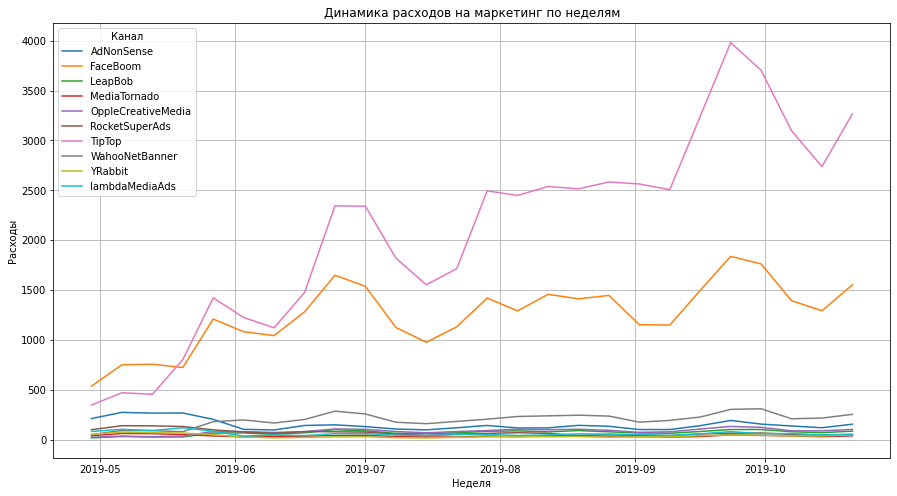

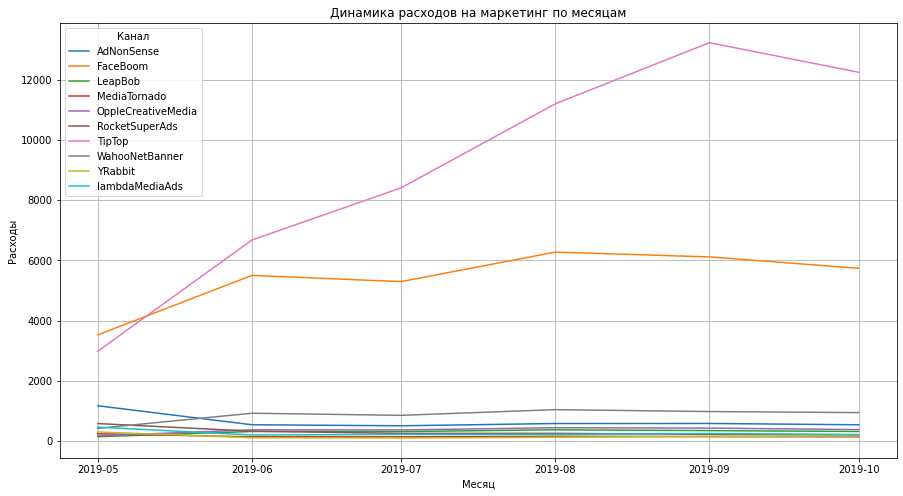

In [32]:

costs['week'] = costs['dt'].dt.to_period('W').dt.start_time
weekly_spend = (
    costs.groupby(['week', 'channel'])
    .agg(total_spent=('costs', 'sum'))
    .reset_index()
)

plt.figure(figsize=(15, 8))
for channel in weekly_spend['channel'].unique():
    channel_data = weekly_spend[weekly_spend['channel'] == channel]
    plt.plot(channel_data['week'], channel_data['total_spent'], label=channel)

plt.title('Динамика расходов на маркетинг по неделям')
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.legend(title='Канал')
plt.grid(True)
plt.show()

costs['month'] = costs['dt'].dt.to_period('M').dt.to_timestamp()
monthly_spend = (
    costs.groupby(['month', 'channel'])
    .agg(total_spent=('costs', 'sum'))
    .reset_index()
)

plt.figure(figsize=(15, 8))
for channel in monthly_spend['channel'].unique():
    channel_data = monthly_spend[monthly_spend['channel'] == channel]
    plt.plot(channel_data['month'], channel_data['total_spent'], label=channel)

plt.title('Динамика расходов на маркетинг по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.legend(title='Канал')
plt.grid(True)
plt.show()




Больше всего было потрачено на TipTop и FaceBoom,что по неделям, что по месяцам

In [33]:
cac_by_channel = (profiles
      .groupby('channel')
      .agg(
          users=('user_id','nunique'),
          acq_cost=('acquisition_cost', 'sum'))
      .sort_values(by='acq_cost', ascending=False)
       .reset_index()
      )
cac_by_channel['cac'] = cac_by_channel['acq_cost'] / cac_by_channel['users']
cac_by_channel['cac %'] = ((cac_by_channel['acq_cost'] / total_costs) * 100).round(2)

cac_by_channel

,channel,users,acq_cost,cac,cac %
0,TipTop,19561,54751.30,2.799003,51.90
1,FaceBoom,29144,32445.60,1.113286,30.75
2,WahooNetBanner,8553,5151.00,0.602245,4.88
3,AdNonSense,3880,3911.25,1.008054,3.71
4,OppleCreativeMedia,8605,2151.25,0.250000,2.04
5,RocketSuperAds,4448,1833.00,0.412095,1.74
6,LeapBob,8553,1797.60,0.210172,1.70
7,lambdaMediaAds,2149,1557.60,0.724802,1.48
8,MediaTornado,4364,954.48,0.218717,0.90
9,YRabbit,4312,944.22,0.218975,0.90


можно заметить, что на TipTop и FaceBoom приходится высокая стоимость привлечения пользователей, соответственно и большое количество пришедших юзеров, так же надо отметить, что через organic(без рекламы) пришло 56 тысяч, что является очень хорошим результатом

## Шаг 5. Оцените окупаемость рекламы


In [34]:
observation_date = datetime(2019,11,1).date()
analysis_horizon = 14

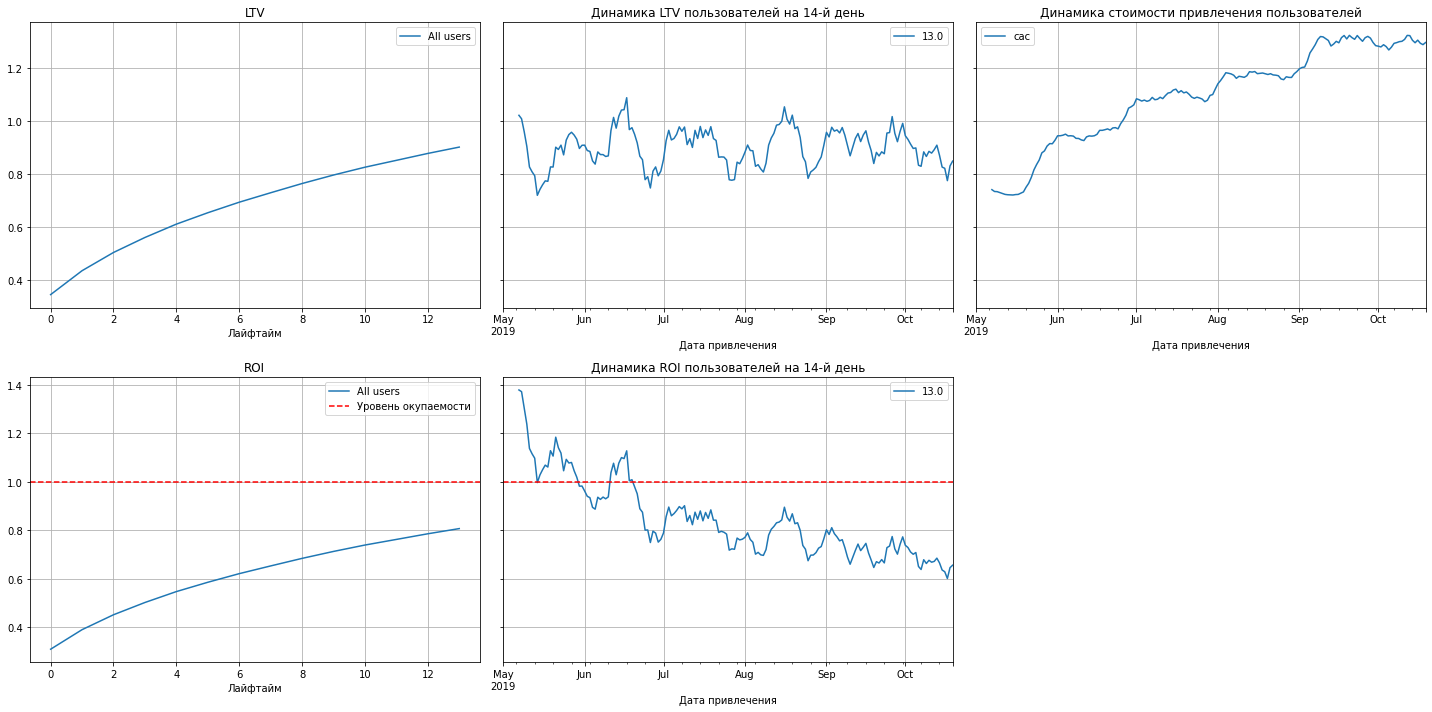

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

1.  ### LTV
   
LTV растёт, но к 14-му дню в среднем не достигает значения CAC.

Выручка от пользователя не покрывает затраты на привлечение.

2. ### Динамика LTV на 14-й день

Видны колебания по датам привлечения: лучшие когорты  достигают всего лишь LTV ≈ 0.8.


3. ### Динамика CAC

Стоимость привлечения пользователей стабильно стремится в вверх.

Высокий CAC делает окупаемость невозможной при текущем LTV.

4. ### Кривые ROI

Ни одна когорта не пересекает уровень ROI = 1.

Это значит, что вложенные в рекламу средства не окупаются за 14 дней.

5. ### Динамика ROI на 14-й день

Есть периоды с ROI около 0.8, но даже в лучшие дни каналы не выходят в плюс.

Потенциал для окупаемости — только при продлении горизонта или оптимизации затрат.


P.S 
Можно заметить, что в мае динамика ROI на 14 день лайфтайма все-таки преодолеловал отметку окупаемости, но не за счет высокого LTV, а за счет снижения CAC


# 2 

## conversion 

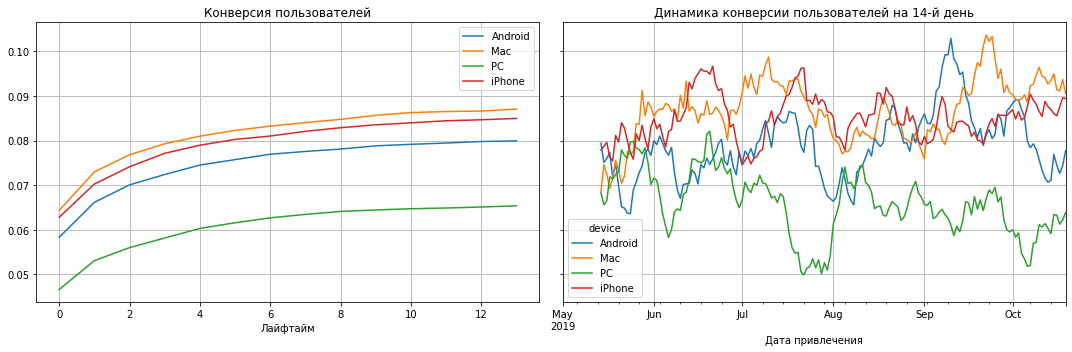

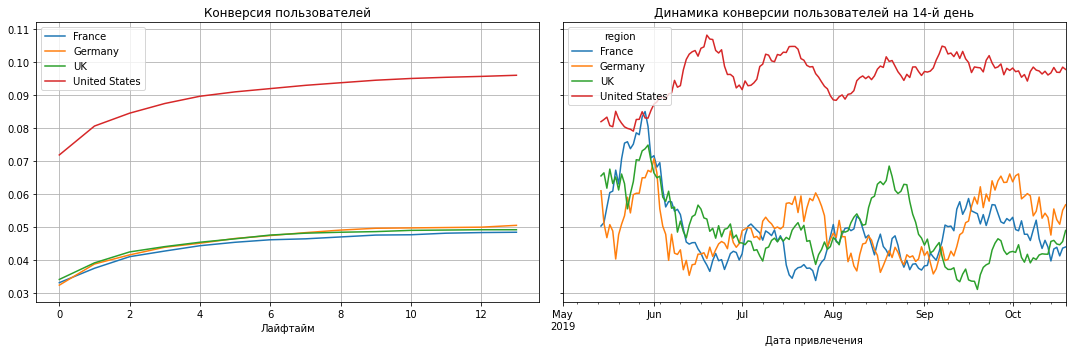

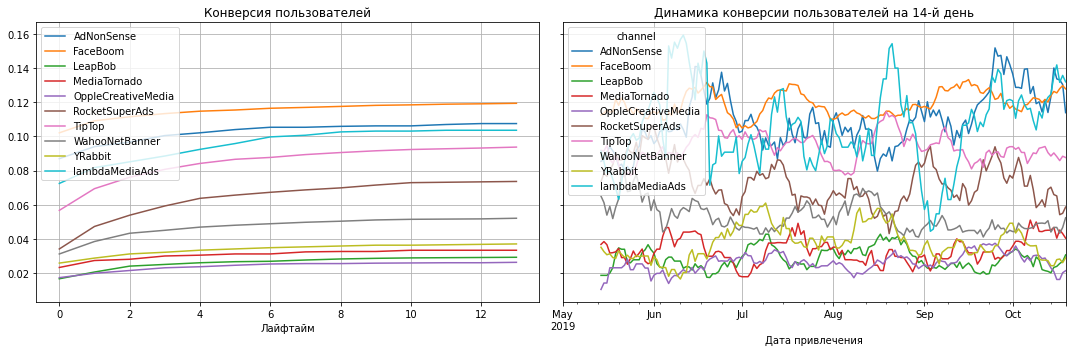

In [36]:
for dimensions in [['device'], ['region'], ['channel']]:
    conversion_raw, conversion_grouped, conversion_history = get_conversion(
        profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
    )
    plot_conversion(conversion_grouped, conversion_history, analysis_horizon, window=14)

## Устройства (device)

### Слева: Конверсия по лайфтайму

Лидируют Mac и Iphone (до ~6.5% к 14 дню).

Android немного ниже (6%), PC — значительно ниже (4.5%).

Это говорит о том, что владельцы Apple-устройств лучше конвертируются.

### Справа: Динамика конверсии

Mac и Iphone стабильно выше Android.

PC показывает устойчиво низкую конверсию.

iPhone демонстрирует волатильную, но высокую конверсию в последние месяцы.

📌 Вывод: стоит инвестировать в Apple-платформы. PC может требовать доработки.

## Страны (region)


### Слева: Конверсия по лайфтайму

США — явный лидер (7.5%), сильно опережает другие страны.

Франция, Германия, UK — все в пределах ~3.5–4%.

### Справа: Динамика конверсии

США стабильно лидирует.

Остальные страны не демонстрируют улучшения во времени.

Германия показывает некоторую положительную динамику с лета.

 Вывод: пользователи из США — основной источник прибыли. Рекомендуется локализовать офферы под них. Германия — потенциальная точка роста.

## Каналы (channel)


### Слева: Конверсия по лайфтайму

FaceBoom, AdNonSense, LamdaMediaAds — лидеры (до 12–14%).

некоторые другие — ниже 5%.

Есть отчётливо слабые каналы: leapbob, OppleCreativeMedia.

### Справа: Динамика конверсии

FaceBoom, AdNonSense, LamdaMediaAds остаются высокими

LeapBob, OppleCreativeMedia — низкий, нестабильный результат.

 Вывод: FaceBoom, AdNonSense и LambdaMediaAds — ключевые каналы с высокой эффективностью. Неэффективные каналы стоит отключить или пересмотреть стратегию.

## retention

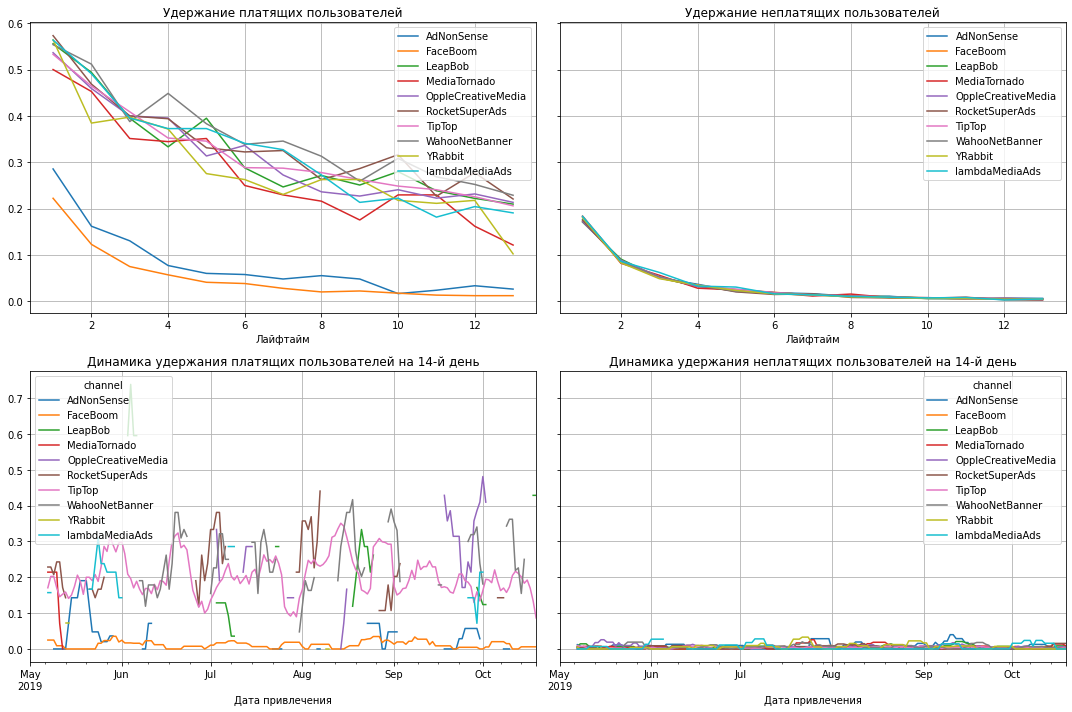

In [37]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, analysis_horizon, window = 7) 

 Удержание платящих:

1. Каналы lambdaMediaAds, RocketSuperAds и TipTop показывают наивысшее удержание платящих пользователей.
2. FaceBoom, AdNonSense — один из самых слабых по удержанию, несмотря на высокий процент платящих.
3. У всех каналов наблюдается естественное падение удержания с ростом лайфтайма.

Удержание неплатящих:

1. Уровень удержания очень низкий и быстро падает у всех каналов — почти до 0 к 5–7 дню.
2. Значимых различий между каналами нет — все ведут к низкому возврату бесплатных пользователей.

Для улучшения возврата неплатящих стоит сосредоточиться на доработке продукта

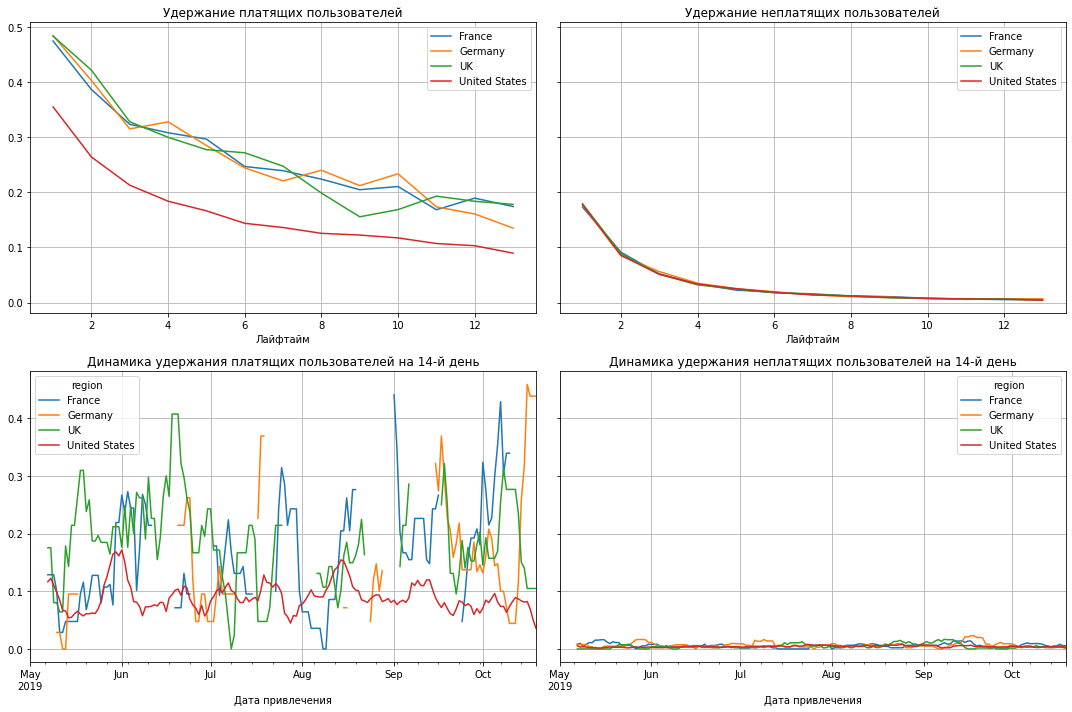

In [38]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, analysis_horizon) 

Удержание платящих:
1. США — стабильно худшее удержание среди всех стран, особенно после 3 дня.
2. UK, Германия и Франция — близкие показатели, но UK чаще лидирует по удержанию на 14-й день.
3. Франция показывает наиболее стабильное удержание к концу периода.

 Удержание неплатящих:
1. Во всех странах крайне низкое удержание — почти ноль уже после 5 дня.
2. Различия между регионами минимальны, и тренд одинаково отрицательный.



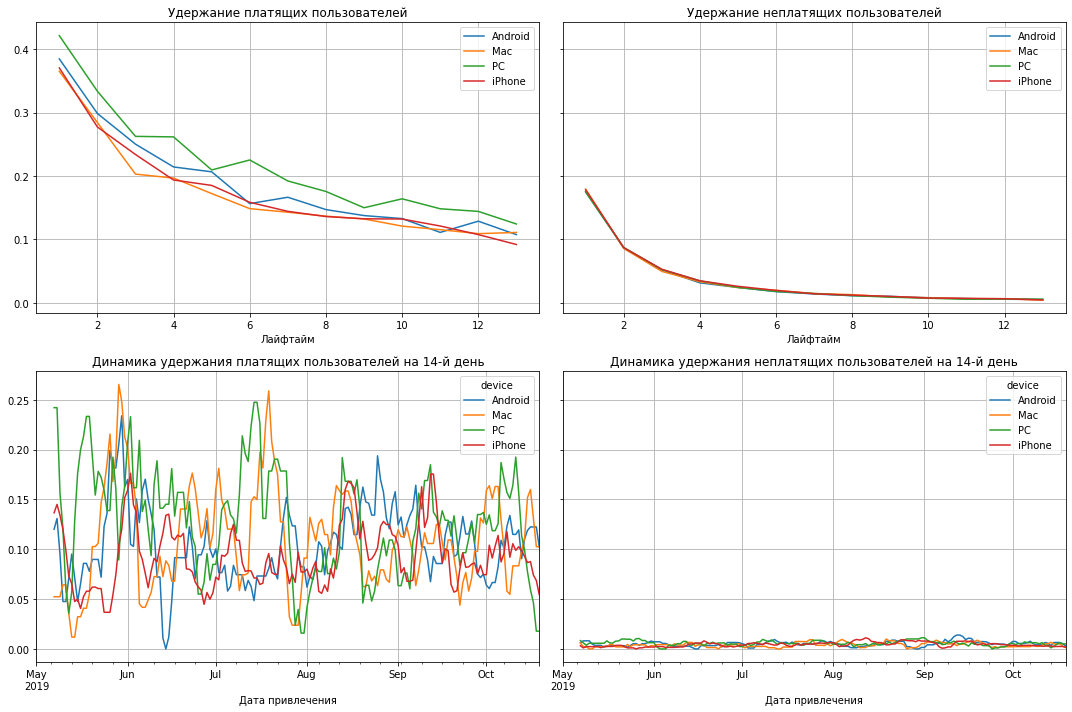

In [39]:
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, analysis_horizon) 

PC — лучший сегмент по удержанию платящих пользователей.

Устройства iPhone дают слабую ltv даже при высокой стоимости привлечения.

# 3

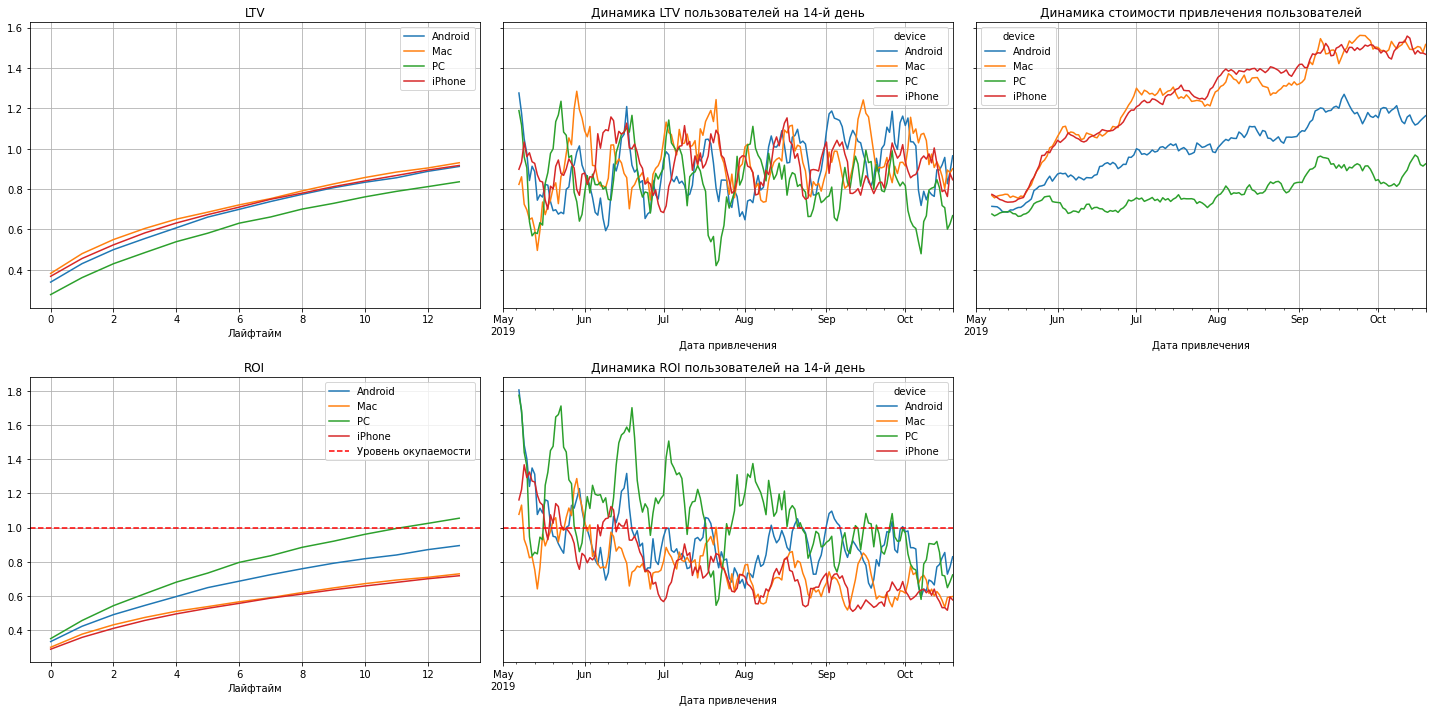

In [40]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

PC — наиболее выгодный сегмент по соотношению LTV и CAC.

iPhone и Mac приносят больше дохода, но их реклама не окупается из-за высокой стоимости привлечения, которая только и делает, что растет со временем

Оптимизация затрат на iOS-платформы критична для повышения общей эффективности.

# 4

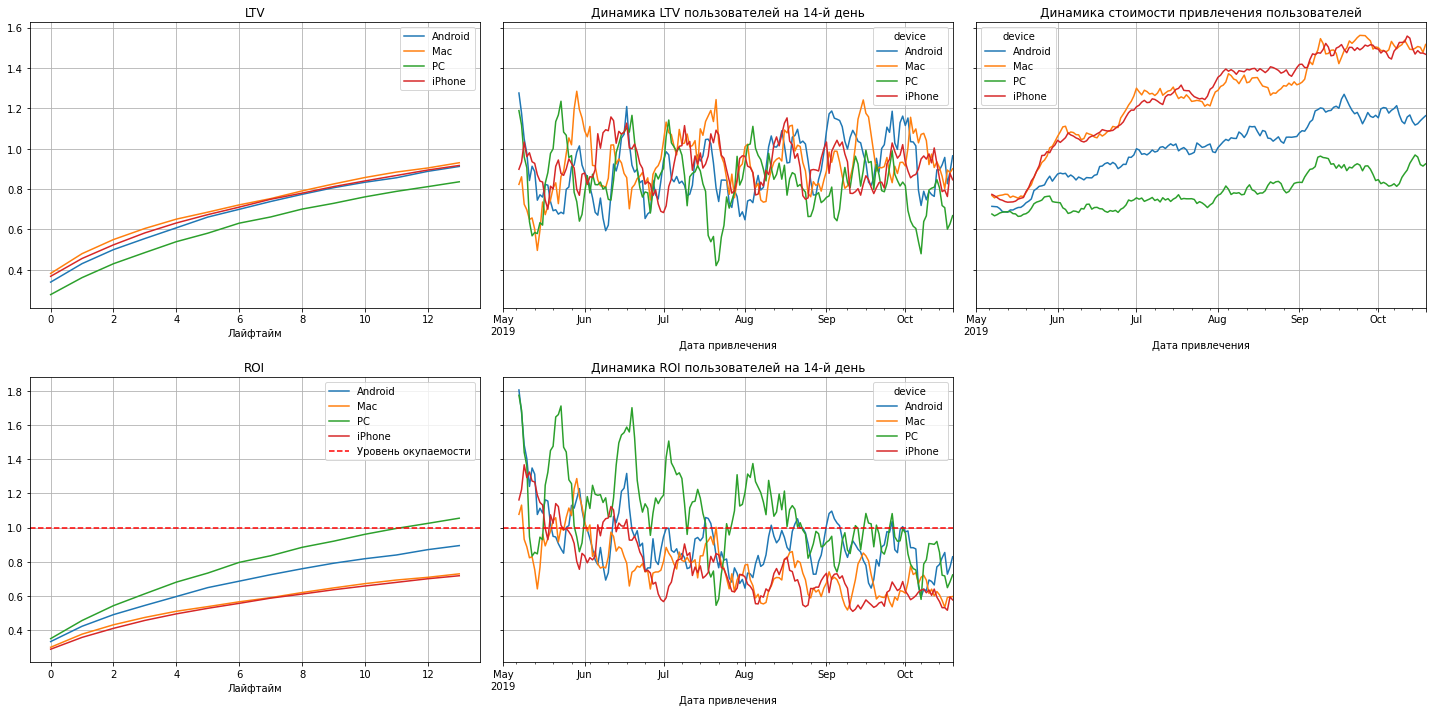

In [41]:

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

## Вывод:
Рекламные кампании в США неэффективны на коротком горизонте — они слишком дорогие.

UK — лучший регион по окупаемости: разумный CAC, хороший LTV, высокий ROI.

Germany и France — также показывают положительный ROI и могут быть использованы в стратегии.



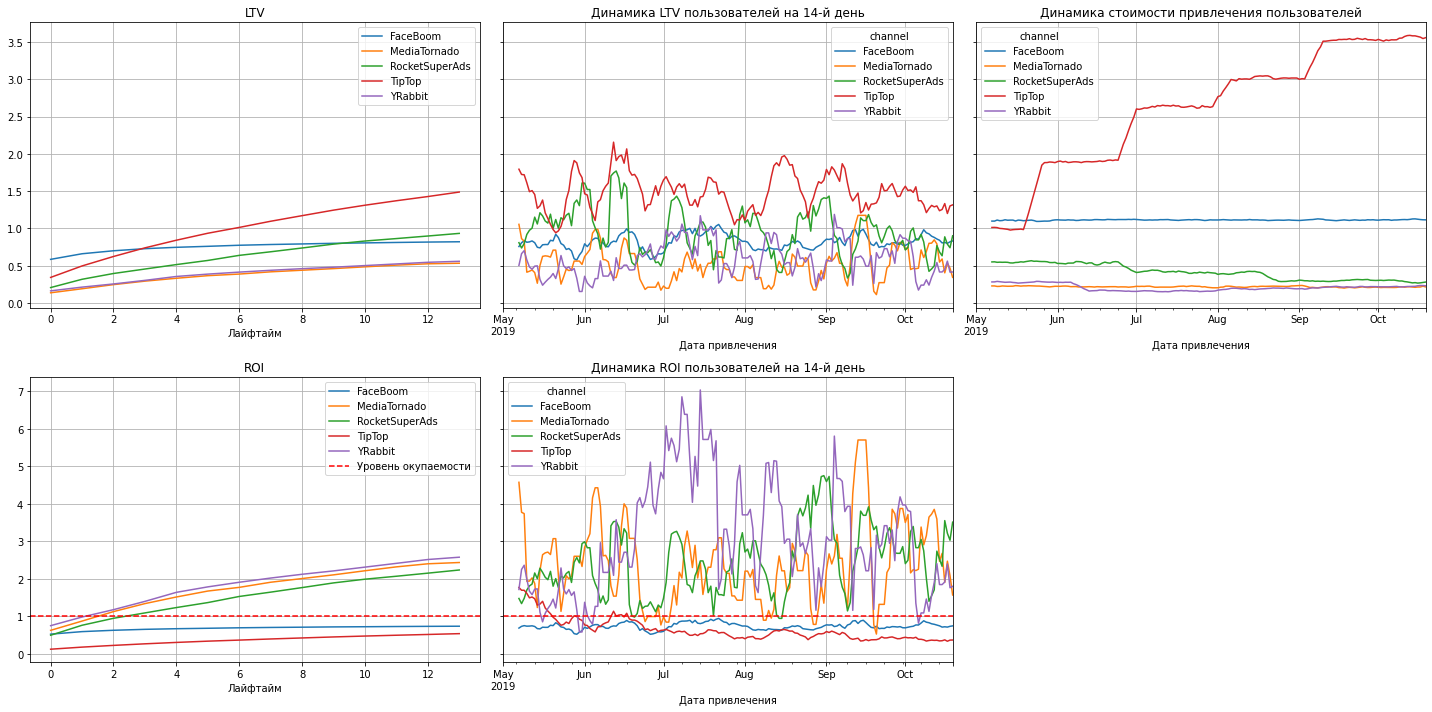

In [42]:
profiles_us = profiles[profiles['region'] == 'United States']
dimensions=['channel']
ltv_raw_us, ltv_grouped_us, ltv_history_us, roi_grouped_us, roi_history_us = get_ltv(
    profiles_us, orders, observation_date, analysis_horizon, dimensions
)
plot_ltv_roi(ltv_grouped_us, ltv_history_us, roi_grouped_us, roi_history_us, analysis_horizon)

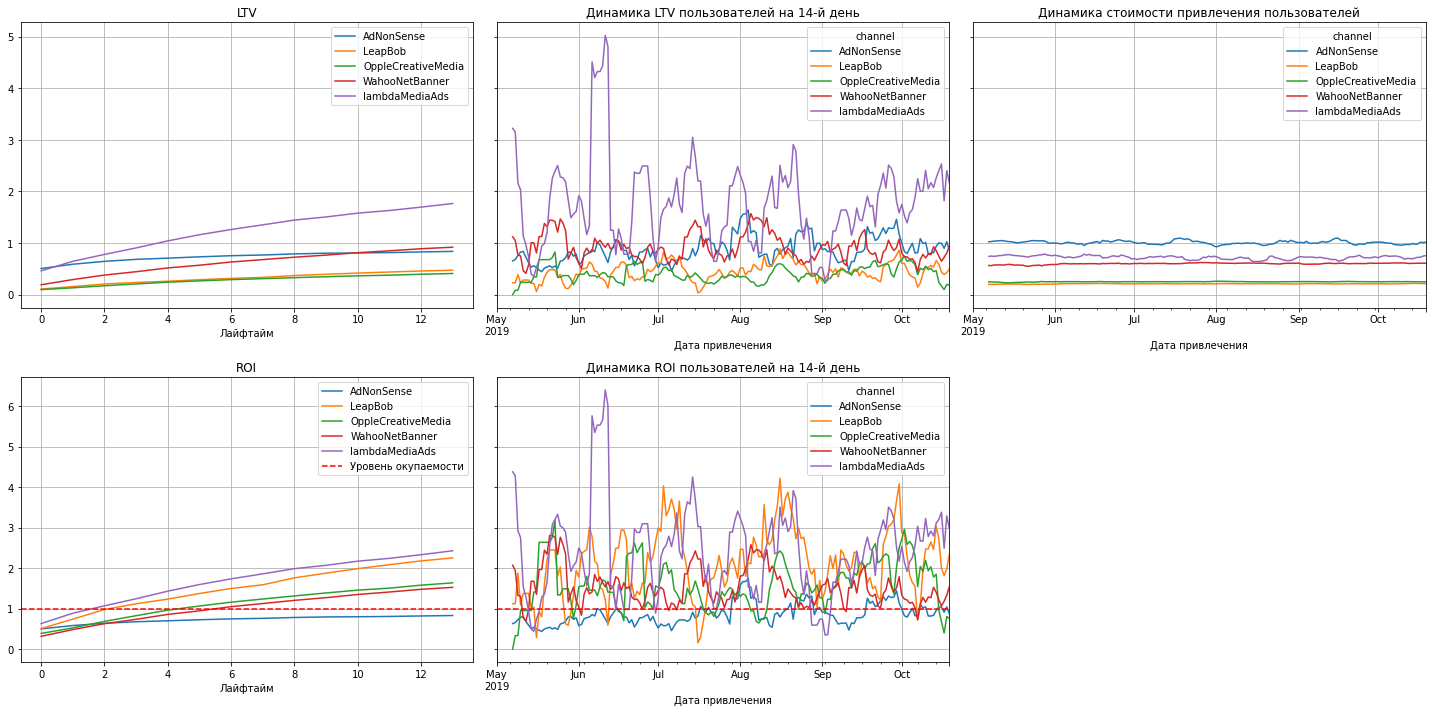

In [43]:
profiles_eu = profiles[profiles['region'].isin(['Germany', 'UK', 'France'])]

dimensions = ['channel']
ltv_raw_eu, ltv_grouped_eu, ltv_history_eu, roi_grouped_eu, roi_history_eu = get_ltv(
    profiles_eu, orders, observation_date, analysis_horizon, dimensions
)

plot_ltv_roi(ltv_grouped_eu, ltv_history_eu, roi_grouped_eu, roi_history_eu, analysis_horizon)


Изучив рекламу в США, можно сделать вывод о том,что одной из главных причин неокупаемости рекламы является повышение стоимости привлечения пользователей по каналу TipTop и использование и без того дорогой рекламы на канале FaceBoom, это можно видеть по ROI, который пересек уровень окупаемости во всех каналах, кроме TipTop и FaceBoom

Если смотреть по Европе, то LambdaMediaAds является очень хорошим источником трафика, который имеет отличные LTV и ROI

# 5

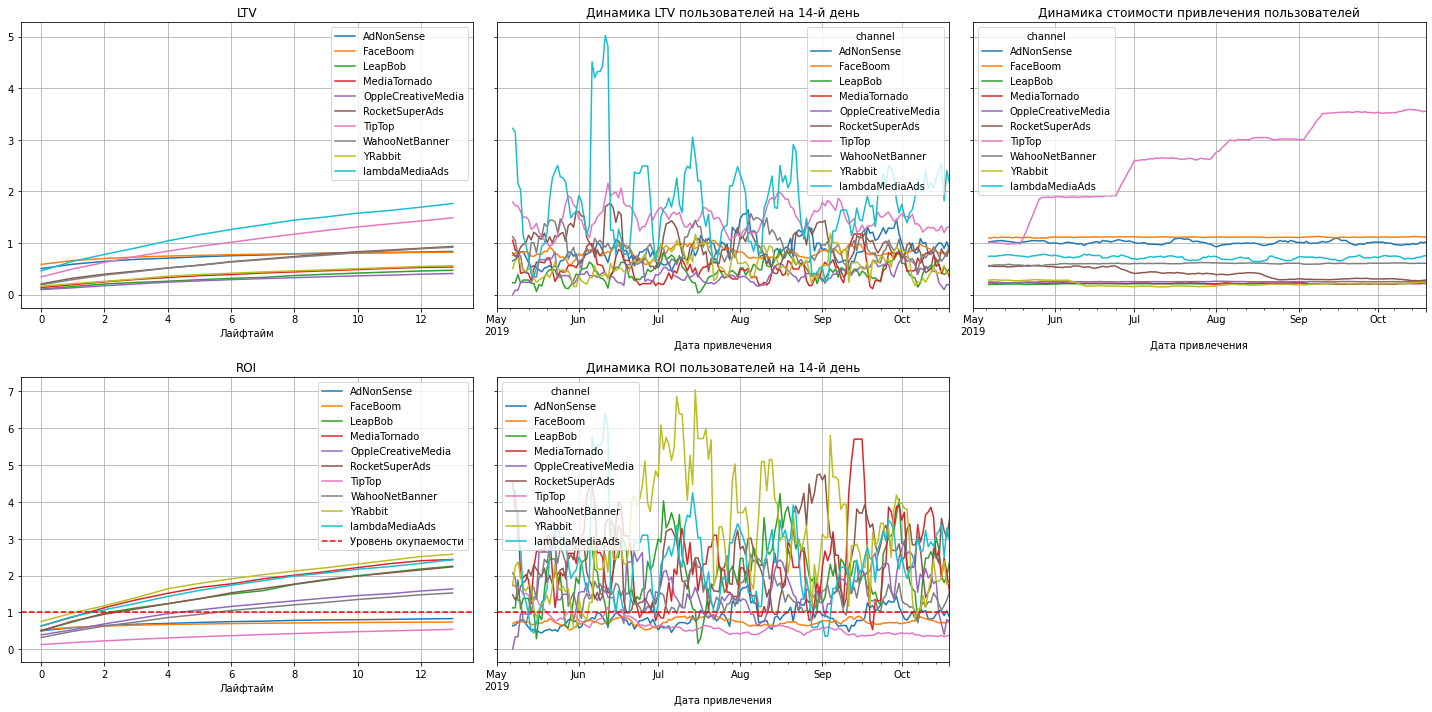

In [44]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window = 7)

Анализ каналов привлечения показал, что каналы с высокими затратами, хоть и обеспечивают значительную конверсию,но не всегда окупаются и показывают низкий ROI. В то же время каналы с умеренными затратами на привлечение демонстрируют наибольшую долгосрочную ценность клиентов и более высокий ROI, что делает их более предпочтительными для долгосрочных стратегий. Наглядно можно увидеть, что LamdaMediaAds показывает выскоий уровень LTV и ROI при этом имея не высокую динамику расходов, а в то же время компания потратив на TipTop почти в 3 раза больше, не получаются с него прибыль, а наборот уходят в минус

Не окупающимися каналами являются: TipTop,FaceBoom,AdNonSense

# Общий вывод по анализу
### 1.Окупается ли реклама, направленная на привлечение пользователей в целом?

Рекламные кампании в текущем виде неэффективны — стоимость привлечения пользователей слишком высока по сравнению с их доходностью в первые две недели. Чтобы выйти в плюс, нужно либо снижать CAC, либо повышать LTV (например, за счёт улучшения удержания, повторных покупок, онбординга и т.п.).

### 2.Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

### Устройства:

Реклама на Andriod & PC — единственная, которая окупается.

iPhone и Mac — слишком дорогие в привлечении и не окупаются, несмотря на хороший LTV, может стоит уменьшить стоимость привлечения

### Страны:

 США: высокая доходность на пользователя, но реклама категорически не окупается — дорогой CAC полностью съедает LTV.

 Великобритания: самый эффективный рынок — хорошее соотношение дохода и стоимости привлечения.

 Германия и Франция: умеренный ROI, но в плюсе.

 Рекомендуется пересмотреть стратегию продвижения в США или перераспределить бюджет в пользу UK и Германии.

 ### Рекламные каналы:

 Наиболее эффективные каналы:
 
YRabbit, LambdaMediaAds — хороший баланс между низким CAC и достойным LTV → высокий ROI.

Наименее эффективные каналы:

TipTop — слишком дорого, реклама не окупается.
Также убыточны FaceBoom, AdsNonSense — по ROI, и по LTV. Все потому что расходы на рекламу через данные каналы слишком высокая и не приносит профита компании


 ### Чем могут быть вызваны проблемы окупаемости?

1. Высокая стоимость привлечения

2. Низкий доход с пользователя

3. Слишком низкий горизонт анализа(если взять горизонт анализа 30 дней, то можно заметить, что некоторые каналы привлечения переходят отметку ROI = 1 )

4. Низкий уровень удержания пользователя

# Шаг 6. Напишите выводы


# Выделите причины неэффективности привлечения пользователей.

1. Крайне низкое удержание неплатящих пользователей,по всем регионам, устройствам, каналам привлечения — проблема глобальная, требует улучшений в продукте или стратегии вовлечения
2. В США пробелма с удержанием пользователей, хоть они и занимают самую первую строчку по конверсии, но юзеры их этой страной очень быстро теряют интерес к продукту и попросту перестают им пользоваться
3. Огромные затраты на FaceBoom и TipTop, которые в конечном итоге из-за большого CAC не приносят дохода 
4. Пользователи пришедшие из AdNonSense и FaceBoom имеют самые низкие показатели удержания пользователей, хоть и лидирует по показателю конверсии, видимо пользователям неинтересен продукт после покупки
5. Высокая стоимость привлечения в США делает ее единственной страной, которая не достигает уровня окупаемости за 2-недельный лайфтайм  
6. Динамика стоимости пользователей Iphone и Mac достигает высоких значений, что делает их неприбыльными для нашей компании на 2-недельном промежутке

# Сформулируйте рекомендации для отдела маркетинга.

1. Сделать акцент на таких каналах, как RocketSuperAds, LambdaMediaAds, которые имеют хорошую конверсию и удержание пользователей, LeapBob также обладает хорошим ROI, но имеет плохую конверсию, так что его развитие не имеет смысла
2. TipTop обладает хорошей конверсией и удержанием, может компании стоить снизит стоимость привлечения
3. Также стоит сделать акцент на Европу в частности UK, которая имеет хорошее удержание
4. Стоит поработать над неплатящей аудиторией
5. Пользователи Android обладают средней конверсией на уровне 0.08 и средним удержанием 0.1, ROI достигает уровня 0.9 стоить акцентировать внимание на пользователей этого девайса, так как PC обладате хорошим удержанием, но плохой конверсией, а Iphone и Mac-наоборот. 